In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


In [ ]:
!pip install nltk
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import collections
import seaborn as sns
from sklearn.model_selection import train_test_split


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import  stopwords, wordnet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Import Training dataset:

In [ ]:
training_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Check for missing data instances

In [ ]:
training_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

#### Check the size of the dataset

In [ ]:
training_data.shape

(7613, 5)

#### Check training data info

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Check the distribution of data instances for both classes

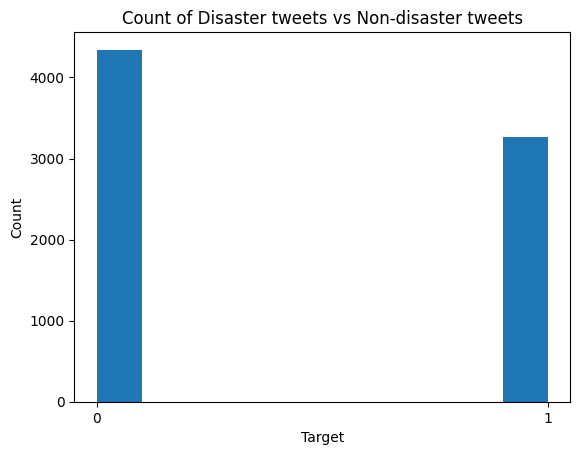

In [ ]:
plt.hist(training_data['target'])

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Count of Disaster tweets vs Non-disaster tweets')
plt.xticks([0, 1])

plt.show()

#### Generate the word cloud for most common words

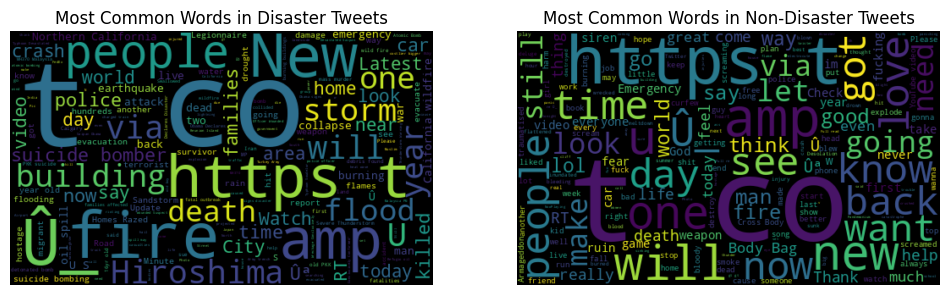

In [ ]:
# Generate word clouds for disaster and non-disaster tweets
disaster_text = " ".join(training_data[training_data["target"] == 1]["text"])
non_disaster_text = " ".join(training_data[training_data["target"] == 0]["text"])

plt.figure(figsize=(12, 5))

# Disaster tweets word cloud
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=500, height=300, background_color="black").generate(disaster_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Disaster Tweets")

# Non-disaster tweets word cloud
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=500, height=300, background_color="black").generate(non_disaster_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Non-Disaster Tweets")

plt.show()

#### Find commonly presents hashtags in the tweets

In [ ]:
# Function to extract hashtags
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Extract hashtags from disaster and non-disaster tweets
disaster_hashtags = sum(training_data[training_data["target"] == 1]["text"].apply(extract_hashtags), [])
non_disaster_hashtags = sum(training_data[training_data["target"] == 0]["text"].apply(extract_hashtags), [])

# Count most common hashtags
disaster_hashtag_counts = collections.Counter(disaster_hashtags).most_common(10)
non_disaster_hashtag_counts = collections.Counter(non_disaster_hashtags).most_common(10)

print("Top 10 Hashtags in Disaster Tweets:", disaster_hashtag_counts, end="\n\n\n")

print("Top 10 Hashtags in Non-Disaster Tweets:", non_disaster_hashtag_counts)

Top 10 Hashtags in Disaster Tweets: [('News', 33), ('news', 23), ('Hiroshima', 21), ('hot', 13), ('prebreak', 13), ('best', 13), ('Japan', 10), ('India', 10), ('yyc', 10), ('Sismo', 9)]


Top 10 Hashtags in Non-Disaster Tweets: [('hot', 18), ('prebreak', 17), ('best', 17), ('news', 15), ('GBBO', 13), ('islam', 11), ('NowPlaying', 10), ('nowplaying', 10), ('jobs', 9), ('EDM', 8)]


#### Check for the present URLs

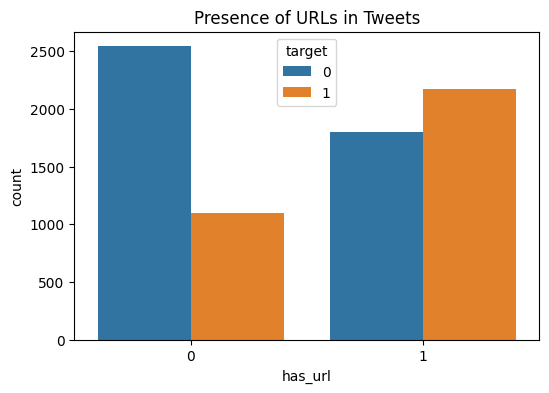

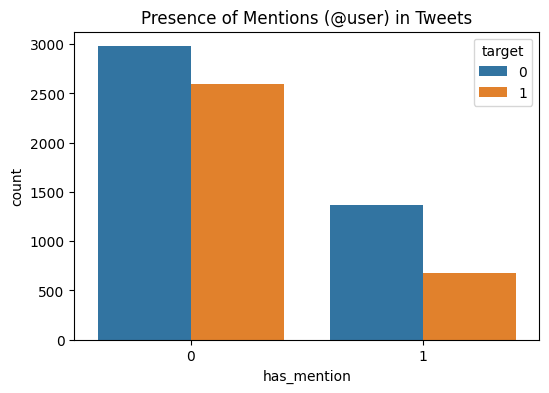

In [ ]:
# Count presence of URLs and mentions
training_data["has_url"] = training_data["text"].apply(lambda x: 1 if "http" in x else 0)
training_data["has_mention"] = training_data["text"].apply(lambda x: 1 if "@" in x else 0)

# Plot URL presence
plt.figure(figsize=(6, 4))
sns.countplot(x="has_url", hue="target", data=training_data)
plt.title("Presence of URLs in Tweets")
plt.show()

# Plot mentions presence
plt.figure(figsize=(6, 4))
sns.countplot(x="has_mention", hue="target", data=training_data)
plt.title("Presence of Mentions (@user) in Tweets")
plt.show()

#### Find the general text length

In [ ]:
training_data["text_length"] = training_data["text"].apply(lambda x: len(x))
print("Real disaster tweet length", training_data[training_data['target'] == 1]['text_length'].mean())
print("Fake disaster tweet length", training_data[training_data['target'] == 0]['text_length'].mean())

Real disaster tweet length 108.11342097217977
Fake disaster tweet length 95.70681713496084


In [ ]:
training_data.drop(['has_url', 'has_mention', 'text_length'], axis=1, inplace=True)

## Spliting dataset into training and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(training_data.drop('target', axis=1), training_data['target'], test_size=0.2, random_state=123)

## Data preprocessing

In [ ]:
def preprocess_text(text):
  """ Function to convert text data into a format suitable for ML tasks.
  """
  # Convert to lowercase
  text = text.lower()

  # Remove URLs
  text = re.sub(r'http\S+', '', text)

  # Remove mentions
  text = re.sub(r'@\w+', '', text)

  # Remove hashtags
  text = re.sub(r'#\w+', '', text)

  # Remove numbers
  text = re.sub(r'\d+', '', text)

  # Remove special characters and digits
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  # Tokenize
  tokens = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Join back into string
  return ' '.join(tokens)

#### Preprocess the train and validation dataset

In [ ]:
for col in ['text', 'keyword', 'location']:
    X_train[col] = X_train[col].astype(str).apply(preprocess_text)
    X_val[col] = X_val[col].astype(str).apply(preprocess_text)

#### Check data after preprocessing

In [ ]:
X_train.head()

,id,keyword,location,text
6445,9220,suicidebombing,usa,turkish troop killed kurdish militant suicide ...
3870,5502,flame,fairy tail,gray ophelia red flame blazing around person s...
2431,3493,derailed,united kingdom,derailed cutlery offer get back track
5355,7643,pandemonium,california,truly scene chaos unprecedented frenzy pandemo...
6496,9288,sunk,nan,everything sunk except fact actually moving st...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

In [ ]:
dummy_count_vectorizer_pipe = Pipeline([('count_vectorizer', CountVectorizer()), ('dummy_classifier', DummyClassifier(strategy="most_frequent"))])

In [ ]:
dummy_count_vectorizer_pipe.fit(X_train['text'], y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('dummy_classifier',
                 DummyClassifier(strategy='most_frequent'))])

In [ ]:
dummy_count_vectorizer_pipe.predict(X_val['text'])

array([0, 0, 0, ..., 0, 0, 0])

# Logistic Regression: Count Vectorizer, TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

logistic_count_vectorizer_pipe = Pipeline([('count_vectorizer', CountVectorizer()), ('logistic_regression', LogisticRegression(random_state=0))])
logistic_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('logistic_regression', LogisticRegression(random_state=0))])


In [ ]:
logistic_count_vectorizer_pipe.fit(X_train['text'], y_train)
logistic_tfidf_pipe.fit(X_train['text'], y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('logistic_regression', LogisticRegression(random_state=0))])

In [ ]:
logistic_count_vectorizer_pipe.predict(X_val['text'])

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
logistic_tfidf_pipe.predict(X_val['text'])

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
logistic_count_vectorizer_pipe.score(X_val['text'], y_val)

0.7944845699277742

In [ ]:
logistic_tfidf_pipe.score(X_val['text'], y_val)

0.793827971109652

## SVM: Count Vectorizer, TF-IDF

In [ ]:
from sklearn.svm import SVC

svm_count_vectorizer_pipe = Pipeline([('count_vectorizer', CountVectorizer()), ('svm', SVC(gamma='auto'))])
svm_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('svm', SVC(gamma='auto'))])

In [ ]:
svm_count_vectorizer_pipe.fit(X_train['text'], y_train)
svm_tfidf_pipe.fit(X_train['text'], y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svm', SVC(gamma='auto'))])

In [ ]:
svm_count_vectorizer_pipe.score(X_val['text'], y_val)

0.5771503611293499

In [ ]:
svm_tfidf_pipe.score(X_val['text'], y_val)

0.5771503611293499

## XGBoost: Count Vectorizer, TF-IDF

In [ ]:
from xgboost import XGBClassifier

xgboost_count_vectorizer_pipe = Pipeline([('count_vectorizer', CountVectorizer()), ('xgb', XGBClassifier())])
xgboost_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()), ('xgb', XGBClassifier())])

In [ ]:
xgboost_count_vectorizer_pipe.fit(X_train['text'], y_train)
xgboost_tfidf_pipe.fit(X_train['text'], y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
xgboost_count_vectorizer_pipe.score(X_val['text'], y_val)

0.7767564018384767

In [ ]:
xgboost_tfidf_pipe.score(X_val['text'], y_val)

0.7695338148391333

In [ ]:
from sklearn.model_selection import GridSearchCV
logistic_params = {
    'logistic_regression__C': [0.1, 1, 10],
    'logistic_regression__penalty': ['l1', 'l2']
}

logistic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logistic_regression', LogisticRegression(random_state=0))
])

logistic_grid = GridSearchCV(logistic_pipeline, logistic_params, cv=5, n_jobs=-1, verbose=1)

logistic_grid.fit(X_train['text'], y_train)

print("Logistic Regression Best Parameters:", logistic_grid.best_params_)
print("Logistic Regression Best Score:", logistic_grid.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

Logistic Regression Best Parameters: {'logistic_regression__C': 1, 'logistic_regression__penalty': 'l2'}
Logistic Regression Best Score: 0.7939244663382594


In [ ]:
svm_params = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear']
}

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(gamma='auto'))
])

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, n_jobs=-1, verbose=1)

svm_grid.fit(X_train['text'], y_train)

print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Score:", svm_grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVM Best Parameters: {'svm__C': 1, 'svm__kernel': 'linear'}
SVM Best Score: 0.7829228243021347


In [ ]:
xgb_params = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__n_estimators': [100, 200, 300]
}

xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, n_jobs=-1, verbose=1)

xgb_grid.fit(X_train['text'], y_train)

print("XGBoost Best Parameters:", xgb_grid.best_params_)
print("XGBoost Best Score:", xgb_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost Best Parameters: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
XGBoost Best Score: 0.7773399014778326


In [ ]:
# Evaluate on validation set
logistic_val_score = logistic_grid.score(X_val['text'], y_val)
svm_val_score = svm_grid.score(X_val['text'], y_val)
xgb_val_score = xgb_grid.score(X_val['text'], y_val)

print("Logistic Regression Validation Score:", logistic_val_score)
print("SVM Validation Score:", svm_val_score)
print("XGBoost Validation Score:", xgb_val_score)

Logistic Regression Validation Score: 0.793827971109652
SVM Validation Score: 0.7892317793827971
XGBoost Validation Score: 0.7767564018384767


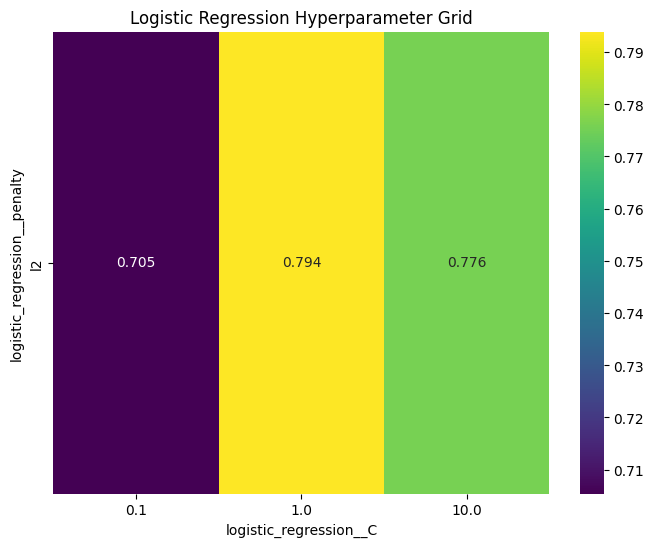

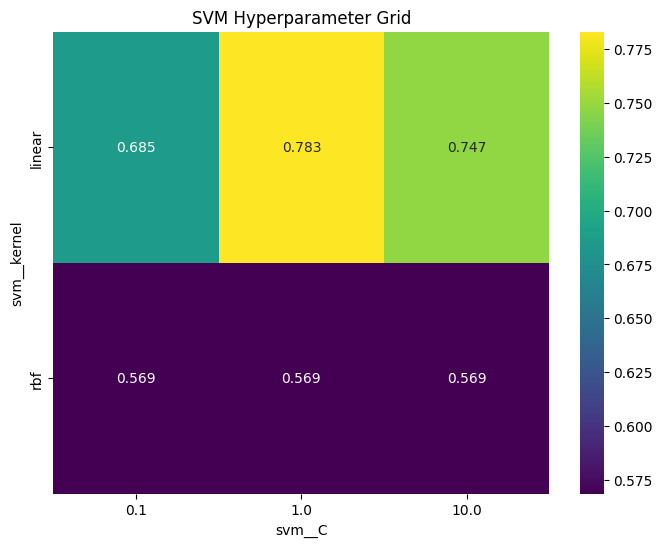

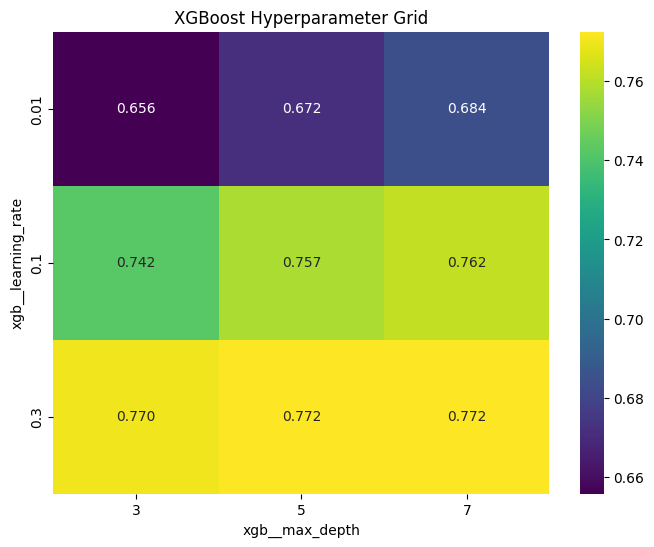

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_grid_search(cv_results, param1, param2, title):
    """
    Plot a heatmap for GridSearchCV results using pivot_table to handle duplicates.

    Args:
    - cv_results: The cv_results_ attribute from GridSearchCV.
    - param1: The name of the first hyperparameter (string).
    - param2: The name of the second hyperparameter (string).
    - title: Title of the plot (string).
    """
    # Extract mean test scores and parameters
    scores = cv_results['mean_test_score']
    param1_values = cv_results[f'param_{param1}']
    param2_values = cv_results[f'param_{param2}']

    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        param1: param1_values,
        param2: param2_values,
        'Mean Test Score': scores
    })

    # Use pivot_table to handle duplicate entries by aggregating with mean
    pivot_table = results_df.pivot_table(index=param2, columns=param1, values='Mean Test Score', aggfunc='mean')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
    plt.title(title)
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.show()

# Plot for Logistic Regression Grid Search
plot_grid_search(logistic_grid.cv_results_, 'logistic_regression__C', 'logistic_regression__penalty',
                 "Logistic Regression Hyperparameter Grid")

# Plot for SVM Grid Search
plot_grid_search(svm_grid.cv_results_, 'svm__C', 'svm__kernel',
                 "SVM Hyperparameter Grid")

# Plot for XGBoost Grid Search
plot_grid_search(xgb_grid.cv_results_, 'xgb__max_depth', 'xgb__learning_rate',
                 "XGBoost Hyperparameter Grid")


In [ ]:
# Updated Logistic Regression Grid
logistic_params = {
    'logistic_regression__C': [0.01, 0.1, 1, 10, 100],
    'logistic_regression__penalty': ['l1', 'l2']
}
logistic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logistic_regression', LogisticRegression(random_state=0))
])

logistic_grid = GridSearchCV(logistic_pipeline, logistic_params, cv=5, n_jobs=-1, verbose=1)

logistic_grid.fit(X_train['text'], y_train)

print("Logistic Regression Best Parameters:", logistic_grid.best_params_)
print("Logistic Regression Best Score:", logistic_grid.best_score_)

# Updated SVM Grid
svm_params = {
    'svm__C': [0.01, 0.1, 1, 5, 10],
    'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(gamma='auto'))
])

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, n_jobs=-1, verbose=1)

svm_grid.fit(X_train['text'], y_train)

print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Score:", svm_grid.best_score_)

# Updated XGBoost Grid
xgb_params = {
    'xgb__max_depth': [2, 4, 6, 8],
    'xgb__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'xgb__n_estimators': [50, 100, 200, 500]
}
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, n_jobs=-1, verbose=1)

xgb_grid.fit(X_train['text'], y_train)

print("XGBoost Best Parameters:", xgb_grid.best_params_)
print("XGBoost Best Score:", xgb_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

Logistic Regression Best Parameters: {'logistic_regression__C': 1, 'logistic_regression__penalty': 'l2'}
Logistic Regression Best Score: 0.7939244663382594
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Best Parameters: {'svm__C': 1, 'svm__kernel': 'linear'}
SVM Best Score: 0.7829228243021347
Fitting 5 folds for each of 64 candidates, totalling 320 fits
XGBoost Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500}
XGBoost Best Score: 0.7727422003284072


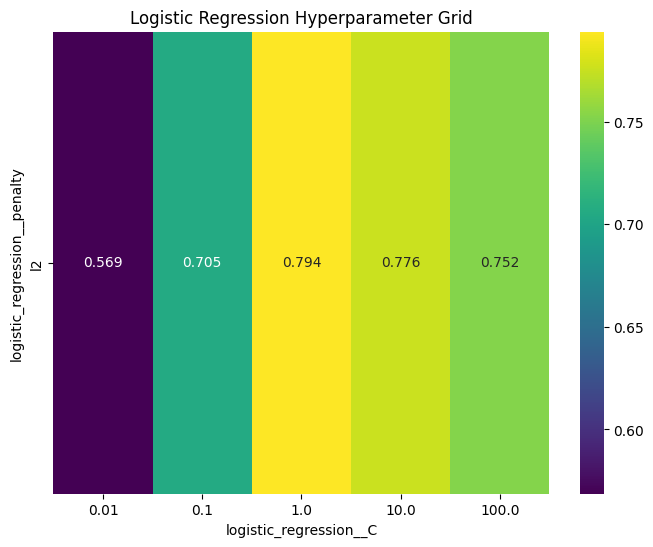

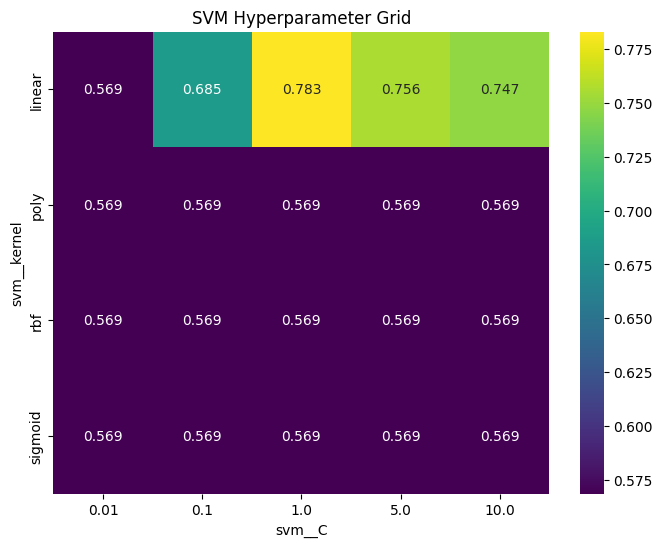

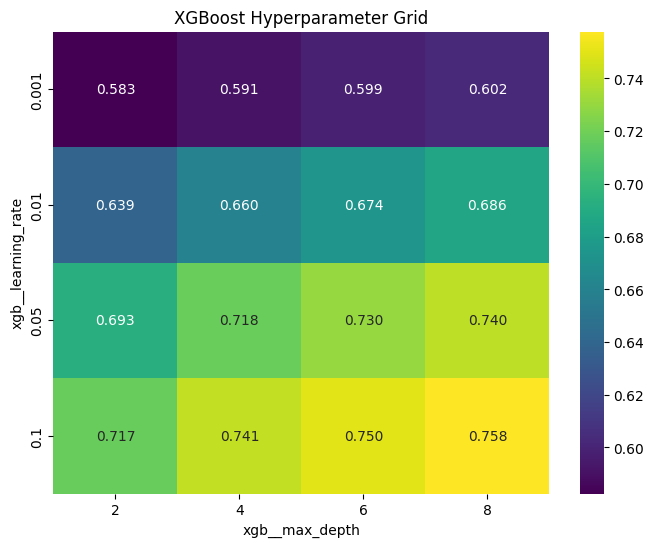

In [ ]:
# Plot for Logistic Regression Grid Search
plot_grid_search(logistic_grid.cv_results_, 'logistic_regression__C', 'logistic_regression__penalty',
                 "Logistic Regression Hyperparameter Grid")

# Plot for SVM Grid Search
plot_grid_search(svm_grid.cv_results_, 'svm__C', 'svm__kernel',
                 "SVM Hyperparameter Grid")

# Plot for XGBoost Grid Search
plot_grid_search(xgb_grid.cv_results_, 'xgb__max_depth', 'xgb__learning_rate',
                 "XGBoost Hyperparameter Grid")

In [ ]:
# Updated Logistic Regression Grid
logistic_params = {
    'logistic_regression__C': [ 2, 4, 6, 8, 10],
    'logistic_regression__penalty': ['l1', 'l2']
}
logistic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logistic_regression', LogisticRegression(random_state=0))
])

logistic_grid = GridSearchCV(logistic_pipeline, logistic_params, cv=5, n_jobs=-1, verbose=1)

logistic_grid.fit(X_train['text'], y_train)

print("Logistic Regression Best Parameters:", logistic_grid.best_params_)
print("Logistic Regression Best Score:", logistic_grid.best_score_)

# Updated SVM Grid
svm_params = {
    'svm__C': [0.8, 0.9, 1, 1.1, 1.2],
    'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(gamma='auto'))
])

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, n_jobs=-1, verbose=1)

svm_grid.fit(X_train['text'], y_train)

print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Score:", svm_grid.best_score_)

# Updated XGBoost Grid
xgb_params = {
    'xgb__max_depth': [ 8, 10, 12, 14],
    'xgb__learning_rate': [ 0.05, 0.1, 0.2, 0.5],
    'xgb__n_estimators': [50, 100, 200, 500]
}
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=5, n_jobs=-1, verbose=1)

xgb_grid.fit(X_train['text'], y_train)

print("XGBoost Best Parameters:", xgb_grid.best_params_)
print("XGBoost Best Score:", xgb_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

Logistic Regression Best Parameters: {'logistic_regression__C': 2, 'logistic_regression__penalty': 'l2'}
Logistic Regression Best Score: 0.7901477832512315
Fitting 5 folds for each of 20 candidates, totalling 100 fits
SVM Best Parameters: {'svm__C': 0.8, 'svm__kernel': 'linear'}
SVM Best Score: 0.787192118226601
Fitting 5 folds for each of 64 candidates, totalling 320 fits
XGBoost Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 12, 'xgb__n_estimators': 200}
XGBoost Best Score: 0.7750410509031199
